In [75]:
import pandas as pd
import numpy as np
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
from keras.models import load_model
from PIL import Image, ImageOps, ImageFilter
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline
np.random.seed(123)
import os
from keras.applications import inception_v3
from keras.applications import InceptionResNetV2
from keras.applications import VGG16
from keras.applications import Xception
from keras.applications import ResNet152
from keras.applications import ResNet101V2, ResNet152V2
import efficientnet.keras as efn
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Model
import itertools

### Image Augmentation to handle class imbalance

### Reading Images from train and test folders

In [5]:
train = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory = '/floyd/input/chest_xray/train',
        class_mode = 'binary',
        target_size = (128, 128),
        batch_size = 7772) 

Found 7772 images belonging to 2 classes.


In [6]:
test = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory = '/floyd/input/chest_xray/test',
        class_mode = 'binary',
        target_size = (128, 128),
        batch_size = 624) 

Found 624 images belonging to 2 classes.


### Spliting labels and Images

In [7]:
test_images, test_labels = next(test)
train_images, train_labels = next(train)

In [8]:
test_labels = np.reshape(test_labels, (len(test_labels),1)).astype(int)
train_labels = np.reshape(train_labels, (len(train_labels),1)).astype(int)

### Creating Validation Set

In [9]:
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.20, random_state=123)

## CNN Baseline

In [34]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer = "Adam",
              metrics=['acc', tf.metrics.Recall()])

In [35]:
cnn1 = cnn.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=50,
                    validation_data=(x_val, y_val),
                      workers = -1)

Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 9s 1ms/step - loss: 0.2639 - acc: 0.8723 - recall_3: 0.6925 - val_loss: 0.0791 - val_acc: 0.9743 - val_recall_3: 0.8637
Epoch 2/10
6217/6217 [==============================] - 8s 1ms/step - loss: 0.0848 - acc: 0.9688 - recall_3: 0.8985 - val_loss: 0.0933 - val_acc: 0.9672 - val_recall_3: 0.9170
Epoch 3/10
6217/6217 [==============================] - 8s 1ms/step - loss: 0.0842 - acc: 0.9683 - recall_3: 0.9262 - val_loss: 0.0659 - val_acc: 0.9711 - val_recall_3: 0.9342
Epoch 4/10
6217/6217 [==============================] - 8s 1ms/step - loss: 0.0584 - acc: 0.9793 - recall_3: 0.9407 - val_loss: 0.0748 - val_acc: 0.9691 - val_recall_3: 0.9460
Epoch 5/10
6217/6217 [==============================] - 8s 1ms/step - loss: 0.0529 - acc: 0.9799 - recall_3: 0.9498 - val_loss: 0.0438 - val_acc: 0.9826 - val_recall_3: 0.9531
Epoch 6/10
6217/6217 [==============================] - 8s 1ms/step - lo

In [36]:
results_train = cnn.evaluate(x_train, y_train)
results_test = cnn.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 0s 602us/step
Train:  [0.004932609713976466, 0.9993566274642944, 0.9729208946228027]
Test:  [1.7193762889275184, 0.7307692170143127, 0.9740020036697388]


In [38]:
# Dictionary to keep track of metrics from all models
scores = {}

In [39]:
scores['CNN'] = [1.7193762889275184, 0.7307692170143127, 0.9740020036697388]

### For Training model

In [10]:
def train_model(model, opt, met, shape, ep):
    """
    model: Model
    opt: Optimizer
    met: Evaluation Metrics
    shape: input shape of Image
    ep: epochs
    """
    mod = model(weights='imagenet',include_top=False, input_shape = shape)
    mod_new = mod.output
    new_model = models.Sequential()
    new_model.add(mod)
    new_model.add(GlobalAveragePooling2D())
    new_model.add(Dense(1024,activation='relu'))
    new_model.add(Dense(1024,activation='relu')) #dense layer 2
    new_model.add(Dense(512,activation='relu')) #dense layer 3
    new_model.add(Dense(1,activation='sigmoid')) #final layer with softmax activation
    
    new_model.compile(optimizer = opt,loss = 'binary_crossentropy',metrics = met )
    nm = new_model.fit(x_train,
             y_train,
             epochs = ep,
             batch_size=50,
             validation_data = (x_val, y_val),
                  workers = -1)
    return new_model, nm
    

### Function to plot confusion matrix of model

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Function to predict on one image

In [12]:
def predictoneimage_cnn(model, path):
    img = load_img(path, target_size=(224, 224))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    if predict > 0.5:
        return 1
    else:
        return 0

### Turning Prediction precentage to class

In [13]:
def prediction(model, images):
    return np.around(model.predict(images))

### Function to plot loss and accuracy with all epochs

In [14]:
def plott(model):
    hist_cnn = model.history
    loss_values = hist_cnn['loss']
    val_loss_values = hist_cnn['val_loss']
    acc_values = hist_cnn['accuracy'] 
    val_acc_values = hist_cnn['val_accuracy']
    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.plot(epochs, loss_values, 'g.', label='Training loss')
    plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, acc_values, 'r.', label='Training acc')
    plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## InceptionV3

In [20]:
mod, plot = train_model(inception_v3.InceptionV3, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 15)

87916544/87910968 [==============================] - 4s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/15
6217/6217 [==============================] - 92s 15ms/step - loss: 0.3126 - accuracy: 0.8720 - recall_1: 0.7265 - val_loss: 0.1437 - val_accuracy: 0.9383 - val_recall_1: 0.8365
Epoch 2/15
6217/6217 [==============================] - 59s 10ms/step - loss: 0.0674 - accuracy: 0.9759 - recall_1: 0.8743 - val_loss: 0.0626 - val_accuracy: 0.9743 - val_recall_1: 0.9007
Epoch 3/15
6217/6217 [==============================] - 60s 10ms/step - loss: 0.0381 - accuracy: 0.9863 - recall_1: 0.9150 - val_loss: 0.0278 - val_accuracy: 0.9904 - val_recall_1: 0.9280
Epoch 4/15
6217/6217 [==============================] - 60s 10ms/step - loss: 0.0184 - accuracy: 0.9942 - recall_1: 0.9372 - val_loss: 0.0250 - val_accuracy: 0.9910 - val_recall_1: 0.9444
Epoch 5/15
6217/6217 [==============================] - 59s 10ms/step - loss: 0.0085 - accuracy: 0.9979 - recall_1: 0.9500 - val_loss: 

In [22]:
results_train = mod.evaluate(x_train, y_train)
results_test = mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 2s 4ms/step
Train:  [0.00024959550582067243, 1.0, 0.9837090969085693]
Test:  [0.950738454476381, 0.8413461446762085, 0.9841669201850891]


In [40]:
scores['InceptionV3'] = [0.950738454476381, 0.8413461446762085, 0.9841669201850891]

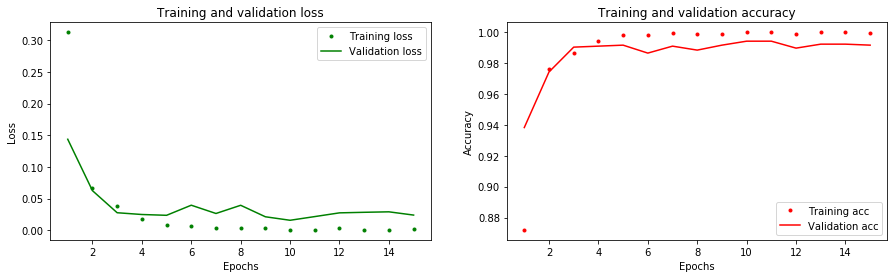

In [23]:
plott(plot)

In [24]:
pred = prediction(mod, test_images)

Confusion matrix, without normalization
[[137  97]
 [  2 388]]


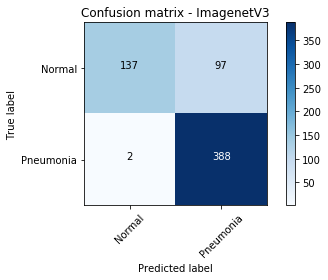

In [25]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - ImagenetV3')

## VGG 16

In [60]:
vgg_mod, vgg_plot = train_model(VGG16, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 10)

58892288/58889256 [==============================] - 3s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 72s 12ms/step - loss: 0.3925 - accuracy: 0.8194 - recall_10: 0.6549 - val_loss: 0.2437 - val_accuracy: 0.9093 - val_recall_10: 0.8219
Epoch 2/10
6217/6217 [==============================] - 64s 10ms/step - loss: 0.1355 - accuracy: 0.9516 - recall_10: 0.8682 - val_loss: 0.0600 - val_accuracy: 0.9807 - val_recall_10: 0.8934
Epoch 3/10
6217/6217 [==============================] - 64s 10ms/step - loss: 0.0681 - accuracy: 0.9747 - recall_10: 0.9088 - val_loss: 0.0588 - val_accuracy: 0.9788 - val_recall_10: 0.9213
Epoch 4/10
6217/6217 [==============================] - 64s 10ms/step - loss: 0.0571 - accuracy: 0.9789 - recall_10: 0.9295 - val_loss: 0.3388 - val_accuracy: 0.8727 - val_recall_10: 0.9297
Epoch 5/10
6217/6217 [==============================] - 64s 10ms/step - loss: 0.0500 - accuracy: 0.9831 - recall_10: 0.9300 - v

In [61]:
results_train = vgg_mod.evaluate(x_train, y_train)
results_test = vgg_mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 3s 4ms/step
Train:  [0.03964818266018307, 0.9861669540405273, 0.9617879986763]
Test:  [0.9210930481935159, 0.7403846383094788, 0.9633430242538452]


In [41]:
scores['VGG16'] = [0.9210930481935159, 0.7403846383094788, 0.9633430242538452]

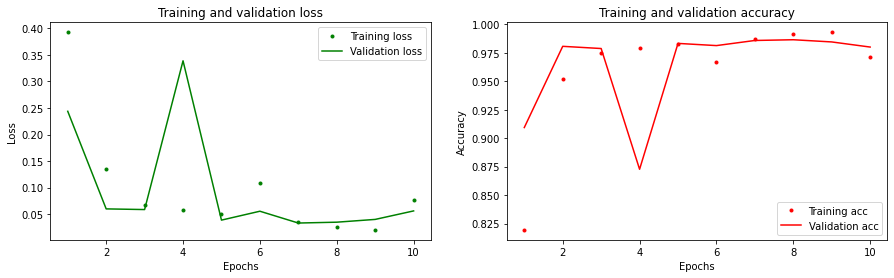

In [62]:
plott(vgg_plot)

In [66]:
vgg_pred = prediction(vgg_mod, test_images)

Confusion matrix, without normalization
[[ 72 162]
 [  0 390]]


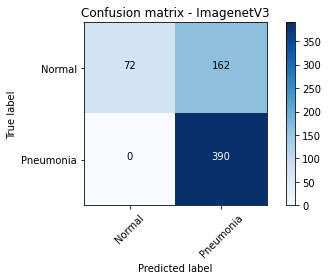

In [67]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, vgg_pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - ImagenetV3')

## EfficientNetB4

In [74]:
ef_mod, ef_plot = train_model(efn.EfficientNetB4, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 10)

71892992/71892840 [==============================] - 3s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 193s 31ms/step - loss: 0.6477 - accuracy: 0.7028 - recall_11: 0.5061 - val_loss: 0.6392 - val_accuracy: 0.7151 - val_recall_11: 0.7097
Epoch 2/10
6217/6217 [==============================] - 142s 23ms/step - loss: 0.4307 - accuracy: 0.8953 - recall_11: 0.7694 - val_loss: 0.4370 - val_accuracy: 0.8412 - val_recall_11: 0.8100
Epoch 3/10
6217/6217 [==============================] - 142s 23ms/step - loss: 0.2008 - accuracy: 0.9418 - recall_11: 0.8354 - val_loss: 0.3044 - val_accuracy: 0.8765 - val_recall_11: 0.8549
Epoch 4/10
6217/6217 [==============================] - 142s 23ms/step - loss: 0.1351 - accuracy: 0.9538 - recall_11: 0.8685 - val_loss: 0.2427 - val_accuracy: 0.9003 - val_recall_11: 0.8799
Epoch 5/10
6217/6217 [==============================] - 142s 23ms/step - loss: 0.1096 - accuracy: 0.9628 - recall_11: 0.889

In [75]:
results_train = ef_mod.evaluate(x_train, y_train)
results_test = ef_mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 4s 6ms/step
Train:  [0.02610859258505756, 0.9937268495559692, 0.9402823448181152]
Test:  [0.8752664648569547, 0.7676281929016113, 0.9426762461662292]


In [42]:
scores['EfficientNetB4'] = [0.8752664648569547, 0.7676281929016113, 0.9426762461662292]

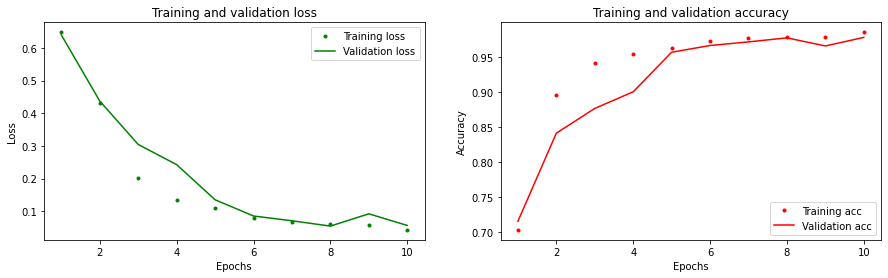

In [76]:
plott(ef_plot)

In [77]:
ef_pred = prediction(ef_mod, test_images)

Confusion matrix, without normalization
[[ 90 144]
 [  1 389]]


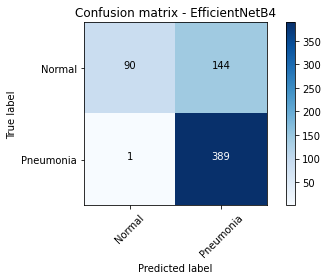

In [80]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, ef_pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - EfficientNetB4')

## EfficientNetB1

In [29]:
ef1_mod, ef1_plot = train_model(efn.EfficientNetB1, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 10)

27164672/27164032 [==============================] - 1s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 118s 19ms/step - loss: 0.5633 - accuracy: 0.7970 - recall_2: 0.7726 - val_loss: 0.4912 - val_accuracy: 0.9023 - val_recall_2: 0.8250
Epoch 2/10
6217/6217 [==============================] - 82s 13ms/step - loss: 0.2450 - accuracy: 0.9279 - recall_2: 0.8536 - val_loss: 0.3176 - val_accuracy: 0.9113 - val_recall_2: 0.8768
Epoch 3/10
6217/6217 [==============================] - 83s 13ms/step - loss: 0.1436 - accuracy: 0.9511 - recall_2: 0.8901 - val_loss: 0.3318 - val_accuracy: 0.8540 - val_recall_2: 0.9018
Epoch 4/10
6217/6217 [==============================] - 83s 13ms/step - loss: 0.0969 - accuracy: 0.9673 - recall_2: 0.9114 - val_loss: 0.1465 - val_accuracy: 0.9492 - val_recall_2: 0.9190
Epoch 5/10
6217/6217 [==============================] - 83s 13ms/step - loss: 0.0736 - accuracy: 0.9756 - recall_2: 0.9249 - val_loss:

In [30]:
results_train = ef1_mod.evaluate(x_train, y_train)
results_test = ef1_mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 2s 4ms/step
Train:  [0.011878194365166853, 0.9983915090560913, 0.9594538807868958]
Test:  [0.6039071480433146, 0.8253205418586731, 0.9610865712165833]


In [43]:
scores['EfficientNetB1'] = [0.6039071480433146, 0.8253205418586731, 0.9610865712165833]

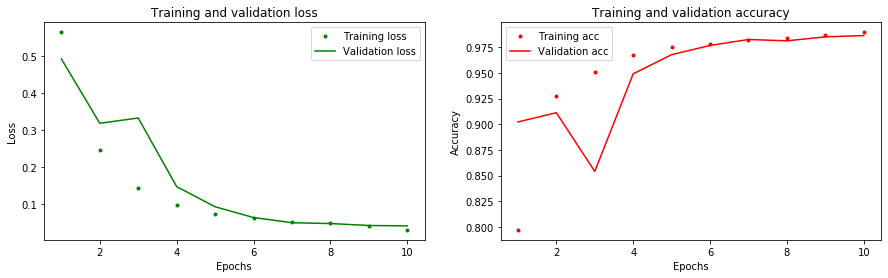

In [31]:
plott(ef1_plot)

In [32]:
ef1_pred = prediction(ef1_mod, test_images)

Confusion matrix, without normalization
[[128 106]
 [  3 387]]


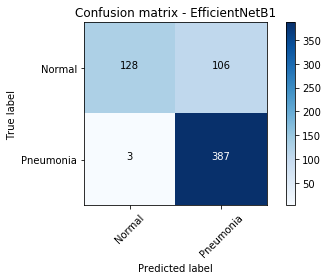

In [33]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, ef1_pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - EfficientNetB1')

## ResNet152

In [15]:
rn_mod, rn_plot = train_model(ResNet152, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 10)

234700800/234698864 [==============================] - 10s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 366s 59ms/step - loss: 0.2003 - accuracy: 0.9324 - recall: 0.8459 - val_loss: 18.5176 - val_accuracy: 0.4830 - val_recall: 0.8198
Epoch 2/10
6217/6217 [==============================] - 220s 35ms/step - loss: 0.0404 - accuracy: 0.9873 - recall: 0.8028 - val_loss: 65.6139 - val_accuracy: 0.4830 - val_recall: 0.7981
Epoch 3/10
6217/6217 [==============================] - 220s 35ms/step - loss: 0.0115 - accuracy: 0.9982 - recall: 0.7972 - val_loss: 168.8940 - val_accuracy: 0.4830 - val_recall: 0.7957
Epoch 4/10
6217/6217 [==============================] - 221s 35ms/step - loss: 0.0069 - accuracy: 0.9982 - recall: 0.7959 - val_loss: 219.2359 - val_accuracy: 0.4830 - val_recall: 0.7946
Epoch 5/10
6217/6217 [==============================] - 220s 35ms/step - loss: 0.0065 - accuracy: 0.9982 - recall: 0.7951 - val_loss: 142.

In [16]:
results_train = rn_mod.evaluate(x_train, y_train)
results_test = rn_mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 7s 11ms/step
Train:  [0.14359817546845507, 0.9732990264892578, 0.8737955093383789]
Test:  [1.7053394317626953, 0.7259615659713745, 0.878918468952179]


In [44]:
scores['ResNet152'] = [1.7053394317626953, 0.7259615659713745, 0.878918468952179]

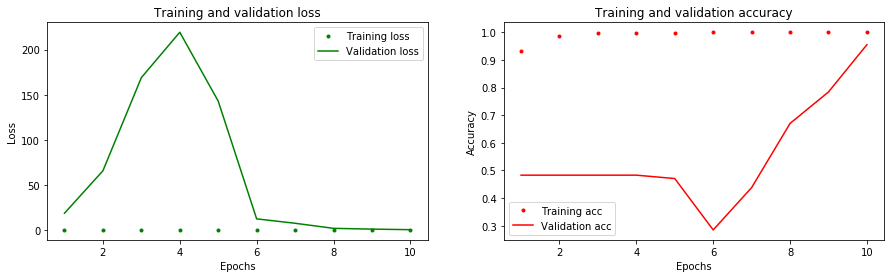

In [17]:
plott(rn_plot)

In [18]:
rn_pred = prediction(rn_mod, test_images)

Confusion matrix, without normalization
[[ 63 171]
 [  0 390]]


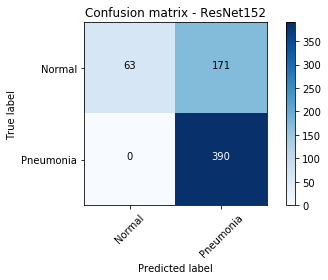

In [19]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, rn_pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - ResNet152')

## InceptionResNetV2

In [47]:
irn_mod, irn_plot = train_model(InceptionResNetV2, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 10)

219062272/219055592 [==============================] - 10s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 212s 34ms/step - loss: 0.3125 - accuracy: 0.8945 - recall_5: 0.7728 - val_loss: 0.2867 - val_accuracy: 0.8913 - val_recall_5: 0.8800
Epoch 2/10
6217/6217 [==============================] - 129s 21ms/step - loss: 0.0854 - accuracy: 0.9690 - recall_5: 0.9072 - val_loss: 0.1149 - val_accuracy: 0.9633 - val_recall_5: 0.9258
Epoch 3/10
6217/6217 [==============================] - 129s 21ms/step - loss: 0.0520 - accuracy: 0.9825 - recall_5: 0.9375 - val_loss: 0.1891 - val_accuracy: 0.9235 - val_recall_5: 0.9454
Epoch 4/10
6217/6217 [==============================] - 129s 21ms/step - loss: 0.0291 - accuracy: 0.9903 - recall_5: 0.9519 - val_loss: 0.1870 - val_accuracy: 0.9820 - val_recall_5: 0.9567
Epoch 5/10
6217/6217 [==============================] - 129s 21ms/step - loss: 0.0163 - accuracy: 0.9953 - recall_5: 0.9609 - va

In [48]:
results_train = irn_mod.evaluate(x_train, y_train)
results_test = irn_mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 5s 8ms/step
Train:  [0.44838379283616303, 0.9953354001045227, 0.978911280632019]
Test:  [0.7133669394713181, 0.8605769276618958, 0.9793888926506042]


In [49]:
scores['InceptionResNetV2'] = [0.7133669394713181, 0.8605769276618958, 0.9793888926506042]

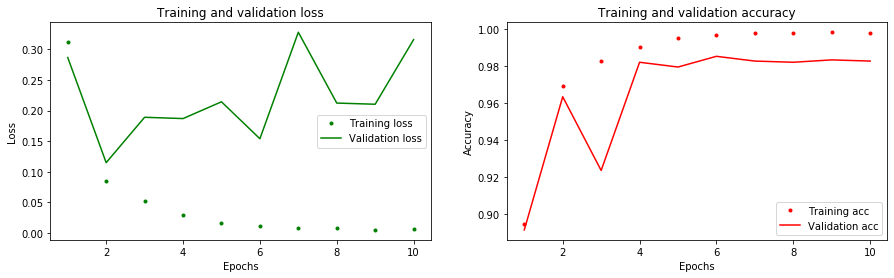

In [50]:
plott(irn_plot)

In [51]:
irn_pred = prediction(irn_mod, test_images)

Confusion matrix, without normalization
[[153  81]
 [  6 384]]


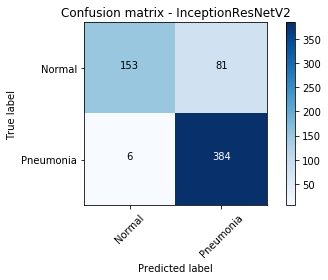

In [62]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, irn_pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - InceptionResNetV2')

## Xception

In [57]:
xc_mod, xc_plot = train_model(Xception, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 10)

83689472/83683744 [==============================] - 4s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 126s 20ms/step - loss: 0.5097 - accuracy: 0.7574 - recall_6: 0.2764 - val_loss: 0.4587 - val_accuracy: 0.7839 - val_recall_6: 0.5452
Epoch 2/10
6217/6217 [==============================] - 110s 18ms/step - loss: 0.3198 - accuracy: 0.9434 - recall_6: 0.6499 - val_loss: 0.3011 - val_accuracy: 0.9588 - val_recall_6: 0.7338
Epoch 3/10
6217/6217 [==============================] - 110s 18ms/step - loss: 0.2089 - accuracy: 0.9698 - recall_6: 0.7816 - val_loss: 0.2310 - val_accuracy: 0.9498 - val_recall_6: 0.8172
Epoch 4/10
6217/6217 [==============================] - 110s 18ms/step - loss: 0.1366 - accuracy: 0.9815 - recall_6: 0.8419 - val_loss: 0.1418 - val_accuracy: 0.9730 - val_recall_6: 0.8609
Epoch 5/10
6217/6217 [==============================] - 110s 18ms/step - loss: 0.0928 - accuracy: 0.9876 - recall_6: 0.8750 - val_l

In [58]:
results_train = xc_mod.evaluate(x_train, y_train)
results_test = xc_mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 3s 5ms/step
Train:  [0.014631898534730334, 0.9995174407958984, 0.9440704584121704]
Test:  [0.4471194614202548, 0.8429487347602844, 0.9462944269180298]


In [59]:
scores['Xception'] = [0.4471194614202548, 0.8429487347602844, 0.9462944269180298]

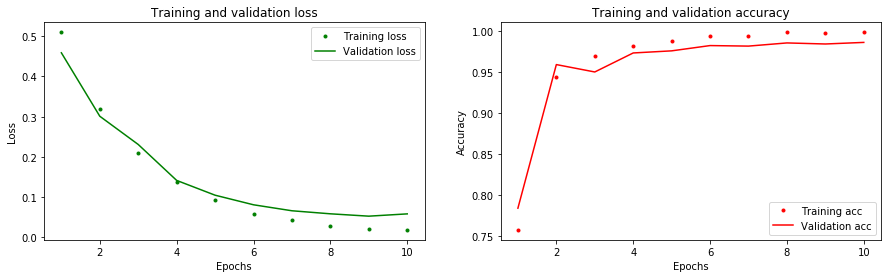

In [60]:
plott(xc_plot)

In [61]:
xc_pred = prediction(xc_mod, test_images)

Confusion matrix, without normalization
[[141  93]
 [  5 385]]


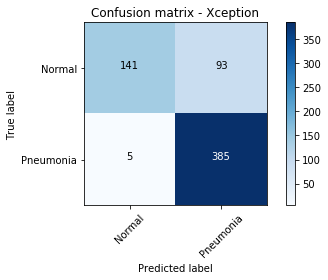

In [63]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, xc_pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - Xception')

## ResNet101V2

In [67]:
r101_mod, r101_plot = train_model(ResNet101V2, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 10)

171319296/171317808 [==============================] - 8s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 182s 29ms/step - loss: 0.2599 - accuracy: 0.9146 - recall_7: 0.7183 - val_loss: 0.1758 - val_accuracy: 0.9395 - val_recall_7: 0.8779
Epoch 2/10
6217/6217 [==============================] - 140s 23ms/step - loss: 0.0477 - accuracy: 0.9855 - recall_7: 0.9071 - val_loss: 0.0866 - val_accuracy: 0.9717 - val_recall_7: 0.9280
Epoch 3/10
6217/6217 [==============================] - 140s 23ms/step - loss: 0.0177 - accuracy: 0.9947 - recall_7: 0.9396 - val_loss: 0.2505 - val_accuracy: 0.9016 - val_recall_7: 0.9494
Epoch 4/10
6217/6217 [==============================] - 140s 23ms/step - loss: 0.0151 - accuracy: 0.9953 - recall_7: 0.9559 - val_loss: 0.0734 - val_accuracy: 0.9801 - val_recall_7: 0.9603
Epoch 5/10
6217/6217 [==============================] - 140s 23ms/step - loss: 0.0062 - accuracy: 0.9987 - recall_7: 0.9637 - val

In [68]:
results_train = r101_mod.evaluate(x_train, y_train)
results_test = r101_mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 4s 7ms/step
Train:  [0.00040102492577604706, 1.0, 0.9827578663825989]
Test:  [0.8169241822682894, 0.8445512652397156, 0.983472466468811]


In [69]:
scores['ResNet101V2'] = [0.8169241822682894, 0.8445512652397156, 0.983472466468811]

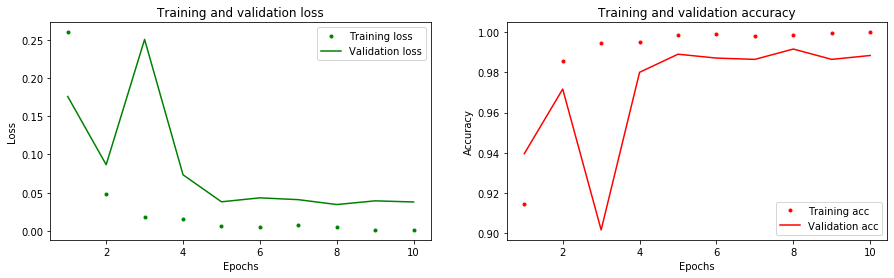

In [70]:
plott(r101_plot)

In [71]:
r101_pred = prediction(r101_mod, test_images)

Confusion matrix, without normalization
[[138  96]
 [  1 389]]


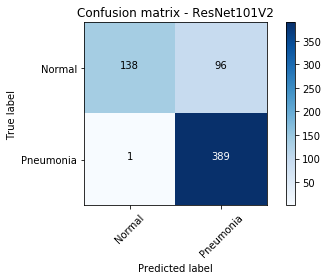

In [72]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, r101_pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - ResNet101V2')

## ResNet152V2

In [76]:
r152_mod, r152_plot = train_model(ResNet152V2, 'sgd', ['accuracy', tf.metrics.Recall()], (128,128,3), ep = 10)

234553344/234545216 [==============================] - 11s 0us/step
Train on 6217 samples, validate on 1555 samples
Epoch 1/10
6217/6217 [==============================] - 277s 45ms/step - loss: 0.2628 - accuracy: 0.9164 - recall_8: 0.7757 - val_loss: 0.2257 - val_accuracy: 0.9228 - val_recall_8: 0.8866
Epoch 2/10
6217/6217 [==============================] - 208s 34ms/step - loss: 0.0427 - accuracy: 0.9883 - recall_8: 0.9111 - val_loss: 0.0758 - val_accuracy: 0.9730 - val_recall_8: 0.9312
Epoch 3/10
6217/6217 [==============================] - 208s 33ms/step - loss: 0.0157 - accuracy: 0.9958 - recall_8: 0.9417 - val_loss: 0.0362 - val_accuracy: 0.9865 - val_recall_8: 0.9511
Epoch 4/10
6217/6217 [==============================] - 208s 34ms/step - loss: 0.0087 - accuracy: 0.9984 - recall_8: 0.9576 - val_loss: 0.0341 - val_accuracy: 0.9871 - val_recall_8: 0.9626
Epoch 5/10
6217/6217 [==============================] - 208s 33ms/step - loss: 0.0056 - accuracy: 0.9989 - recall_8: 0.9663 - va

In [77]:
results_train = r152_mod.evaluate(x_train, y_train)
results_test = r152_mod.evaluate(test_images, test_labels)
print('Train: ',results_train)
print('Test: ',results_test)

624/624 [==============================] - 6s 10ms/step
Train:  [0.0009879855344054607, 1.0, 0.9817174077033997]
Test:  [0.6595848794931021, 0.8733974099159241, 0.9824385643005371]


In [78]:
scores['ResNet152V2'] = [0.6595848794931021, 0.8733974099159241, 0.9824385643005371]

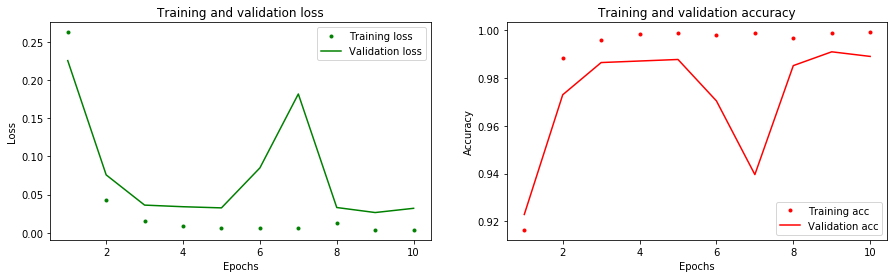

In [79]:
plott(r152_plot)

In [81]:
r152_pred = prediction(r152_mod, test_images)

Confusion matrix, without normalization
[[158  76]
 [  3 387]]


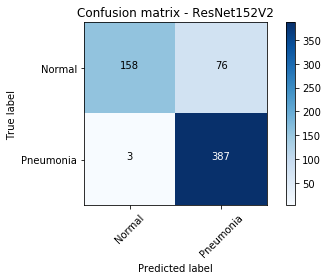

In [82]:
plt.figure()
plot_confusion_matrix(confusion_matrix(test_labels, r152_pred), classes=['Normal', 'Pneumonia'], normalize=False,
                      title='Confusion matrix - ResNet152V2')

In [87]:
percent_pred = r152_mod.predict(test_images)

## Plotting

In [99]:
def return_indexes(target_list, prediction_percentages):
    """
    target_list = false positives, false negatives, true positives, true negatives AFTER boolean conversion
    prediction_percentages = model.predict(testimages)
    
    returns a list of tuples
    [(prediction percentage, index)]
    
    """
    target_list_index = []
    for i in range(len(target_list)-1):
        if target_list[i]:
            target_list_index.append(i)
    
    target_list_percentage_index = []
    if len(target_list_index) == 0:
        return target_list_index
    else:
        for i in target_list_index:
            target_list_percentage_index.append((prediction_percentages[i], i))
            
    target_list_percentage_index.sort(key=lambda x: x[0], reverse=True)
    
    return target_list_percentage_index

In [124]:
def return_percentages_indexes(prediction_percentages,test_labels):
    """
    y_pred = predictions in percentage form between 0 and 1 from model.predict
    test_labels = actual labels 0 or 1
    
    returns 4 items
    true_negatives_index, 
    false_positives_index, 
    false_negatives_index, 
    true_positives_index
    
    They are list of tuples with (percentage predicted, index)
    """
    prediction_percentages = np.concatenate(prediction_percentages)
    y_pred = np.where(prediction_percentages > 0.5, 1, 0)
#     y_pred = np.concatenate(y_pred)
    
    bool_prediction = y_pred > 0
    ground_truth = np.concatenate(test_labels) > 0
    
    false_positives = ~ground_truth & bool_prediction
    false_negatives = ground_truth & ~bool_prediction
    true_positives = ground_truth & bool_prediction
    true_negatives = ~ground_truth & ~bool_prediction
    
    false_positives_index = return_indexes(false_positives, prediction_percentages)
    false_negatives_index = return_indexes(false_negatives, prediction_percentages)
    true_positives_index = return_indexes(true_positives, prediction_percentages)
    true_negatives_index = return_indexes(true_negatives, prediction_percentages)
    
    return true_negatives_index, false_positives_index, false_negatives_index, true_positives_index

In [125]:
true_negatives_index, false_positives_index, false_negatives_index, true_positives_index = return_percentages_indexes(percent_pred , test_labels)

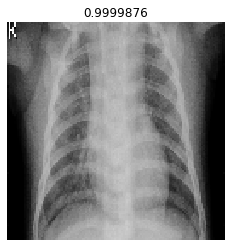

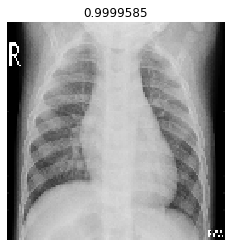

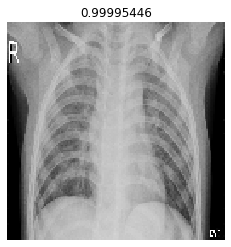

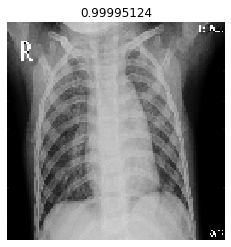

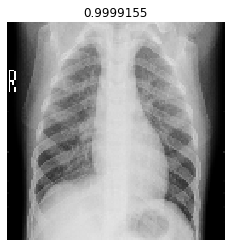

In [141]:
for i in false_positives_index[:5]:
    plt.imshow(test_images[i[1]])
    plt.title(i[0])
    plt.axis('off')
    plt.savefig('false_postitive_{}.png'.format(i[0]), bbox_inches ='tight',pad_inches=0)
    plt.show()

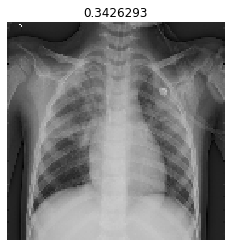

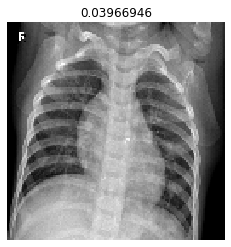

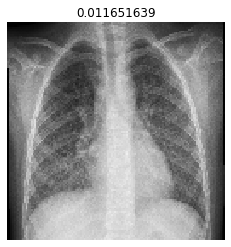

In [140]:
for i in false_negatives_index[:5]:
    plt.imshow(test_images[i[1]])
    plt.title(i[0])
    plt.axis('off')
    plt.savefig('false_negative_{}.png'.format(i[0]), bbox_inches ='tight',pad_inches=0)
    plt.show()

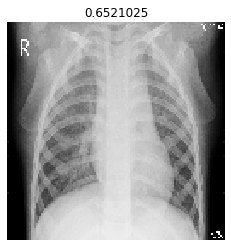

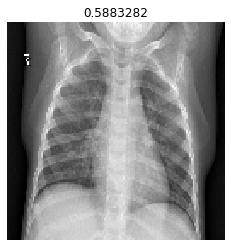

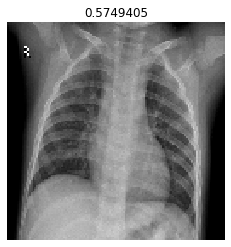

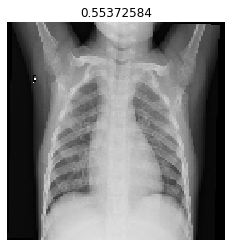

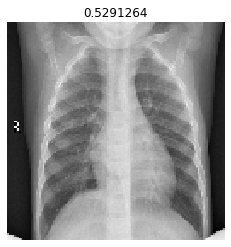

In [142]:
for i in false_positives_index[-5:]:
    plt.imshow(test_images[i[1]])
    plt.title(i[0])
    plt.axis('off')
    plt.savefig('false_positive_{}.png'.format(i[0]), bbox_inches ='tight',pad_inches=0)
    plt.show()

In [143]:
scores_df = pd.DataFrame.from_dict(scores, orient='index',columns = ['Loss', 'Accuracy', 'Recall'])
scores_df.index.name = 'Models'

In [144]:
scores_df.sort_values(by = 'Accuracy', ascending = False)

,Loss,Accuracy,Recall
Models,,,
ResNet152V2,0.659585,0.873397,0.982439
InceptionResNetV2,0.713367,0.860577,0.979389
ResNet101V2,0.816924,0.844551,0.983472
Xception,0.447119,0.842949,0.946294
InceptionV3,0.950738,0.841346,0.984167
EfficientNetB1,0.603907,0.825321,0.961087
EfficientNetB4,0.875266,0.767628,0.942676
VGG16,0.921093,0.740385,0.963343
CNN,1.719376,0.730769,0.974002
